In [7]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric.utils
import torch, random, torchaudio, os, time, math, torch_geometric
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from torchvision import transforms as transforms
import torchaudio.transforms as audio_transforms

class MIMII(Dataset):
    """
    用于小样本学习的MIMII数据集
    """
    def __init__(self, root_dir, machine_classes=['fan', 'pump', 'slider', 'valve'], 
                 model_ids=['id_00', 'id_02', 'id_04', 'id_06'], categories=['normal', 'abnormal'], mode='train',
                 resample=False, resample_rate=None, resize=False, resize_shape=None):
        self.root_dir = root_dir
        self.machine_classes = machine_classes  # ['fan', 'pump', 'slider', 'valve']
        self.model_ids = model_ids  # ['id_00', 'id_02', 'id_04', 'id_06']
        self.categories = categories  # ['normal', 'abnormal']
        self.mode = mode
        self.resample = resample
        self.resample_rate = resample_rate
        self.data = self._load_class_list() # 结构: {机械种类_机械型号_是否故障: [音频路径]}
        self.classes = list(self.data.keys()) # 共32种 如: 'fan_id_00_normal'
        self.labels_to_indexs = {class_str:i for i, class_str in enumerate(self.classes)}
        self.index_to_labels = {i:class_str for i, class_str in enumerate(self.classes)}
        self.resize = resize
        self.resize_shape =resize_shape

    def _load_class_list(self):
        class_list = {}
        for machine_class in self.machine_classes:
            for model in self.model_ids:
                for category in self.categories:
                    class_id = f'{machine_class}_{model}_{category}'
                    class_list[class_id] = []
                    category_dir = os.path.join(self.root_dir, machine_class, machine_class, model, category)
                    class_list[class_id] = [os.path.join(category_dir, f) for f in os.listdir(category_dir) if f.endswith('.wav')]

        return class_list

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        support_set, query_set = [], []
        eps = 1e-10
        if self.resize:
            transform = transforms.Resize(self.resize_shape)

        # 随机为每一个类选择此类的1个样本, 共32个样本, 组合为 Support Set
        for class_id in self.classes:
            file_path = random.choice(self.data[class_id])
            waveform, sample_rate = torchaudio.load(file_path)
            num_samples = waveform.shape[1]
            if self.resample:
                waveform = torchaudio.transforms.Resample(sample_rate, self.resample_rate)(waveform)
            support_set.append((waveform, self.labels_to_indexs[class_id]))

        # 选择一个随机的 机械_型号_是否故障作为 Query Set
        query_class = random.choice(self.classes)
        query_file_path = random.choice(self.data[query_class])
        query_waveform, sample_rate = torchaudio.load(query_file_path)
        num_samples = query_waveform.shape[1]
        if self.resample:
                query_waveform = torchaudio.transforms.Resample(sample_rate, self.resample_rate)(query_waveform)

        query_set = (query_waveform, self.labels_to_indexs[query_class])

        random.shuffle(support_set)

        return support_set, query_set
    
    def __repr__(self):
        return f"Label-to-index --> {self.labels_to_indexs}"


In [8]:
# import datasets
# from torch.utils.data import random_split, DataLoader

# mimii_dataset = datasets.MIMII(root_dir='./data/mimii/-6dB_SNR', N=32, K=2, query_size=3)
# # train_size = int(0.1 * len(mimii_dataset))
# # test_size = len(mimii_dataset) - train_size
# # train_dataset, test_dataset = random_split(mimii_dataset, [train_size, test_size])
# # train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
# # test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)
# dataloader = DataLoader(mimii_dataset)

Shape of waveform: torch.Size([8, 160000])
Sample rate of waveform: 16000


/tmp/ipykernel_31524/996296930.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.plot(waveform[0].T.numpy())


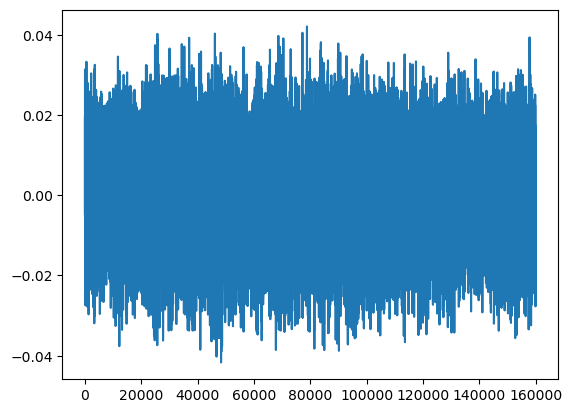

In [9]:
import utils

batch_size = 256
sample_rate = 16000
resample_rate = 8000
args = utils.Args(seed=42)
device = args.device


if device != "cpu":
    num_workers = 1
    pin_memory = True
    torch.cuda.manual_seed(args.seed)
else:
    num_workers = 0
    pin_memory = False
    torch.manual_seed(args.seed)

dataset = MIMII(root_dir='./data/mimii/-6dB_SNR')
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

waveform_shape = 0
for support_set, _ in data_loader:
    for waveform, label in support_set:
        waveform = waveform.squeeze(0)
        print("Shape of waveform: {}".format(waveform.size()))
        print("Sample rate of waveform: {}".format(sample_rate))
        plt.plot(waveform[0].T.numpy())
        waveform_shape = waveform.shape
        break
    break

In [10]:
import torch.nn.functional as F

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        features = x
        x = self.fc1(x)
        return features ,F.log_softmax(x, dim=2)


model = M5(n_input=waveform_shape[0], n_output=32)
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(8, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
)
Numbe

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Train Epoch: 4   |   Loss: 3.509  |  Train Acc:6.25%
Train Epoch: 8   |   Loss: 3.466  |  Train Acc:6.25%
Train Epoch: 12   |   Loss: 3.117  |  Train Acc:12.5%
Train Epoch: 16   |   Loss: 2.962  |  Train Acc:18.75%
Train Epoch: 20   |   Loss: 2.995  |  Train Acc:21.875%
Train Epoch: 24   |   Loss: 2.974  |  Train Acc:12.5%
Train Epoch: 28   |   Loss: 2.836  |  Train Acc:21.875%
Train Epoch: 32   |   Loss: 2.744  |  Train Acc:28.125%
Train Epoch: 36   |   Loss: 2.818  |  Train Acc:21.875%
Train Epoch: 40   |   Loss: 2.675  |  Train Acc:21.875%
Train Epoch: 44   |   Loss: 2.658  |  Train Acc:18.75%
Train Epoch: 48   |   Loss: 3.080  |  Train Acc:28.125%


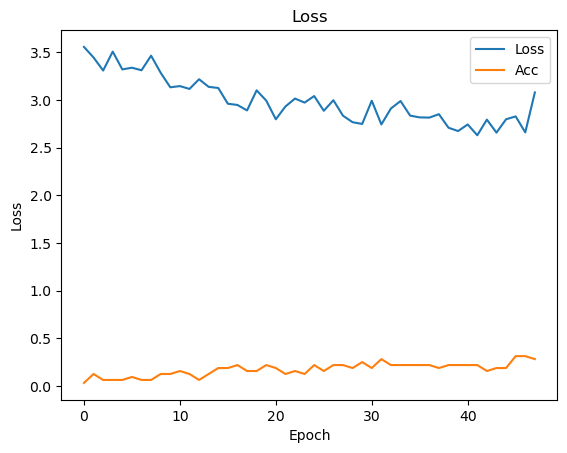

In [12]:
def train(model, num_epochs, data_loader):
    model.train()
    loss_function = nn.CrossEntropyLoss()
    losses = []
    accs = []
    for epoch in range(1, num_epochs+1):
        waveforms, labels = [], []
        for support_set, query_set in data_loader:
            for waveform, label in support_set:
                waveforms.append(waveform.squeeze(0)),
                labels.append(label)
            
            # waveforms.append(query_set[0].squeeze(0))
            # labels.append(query_set[1])

        waveforms = torch.stack(waveforms).to(device)
        labels = torch.tensor(labels, device=device)

        optimizer.zero_grad()
        _, outputs = model(waveforms)
        outputs = outputs.squeeze(1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        acc = torch.sum(outputs.argmax(axis=-1)==labels) / len(labels)
        if epoch%4 ==0:
            print(f"Train Epoch: {epoch}   |   Loss: {loss.item():.3f}  |  Train Acc:{acc *100}%")
        losses.append(loss.item())
        accs.append(acc.cpu().numpy())
        # if epoch > 31:
        #     print(f"In Query || Pred: {outputs.argmax(axis=-1)[32]}, True:{labels[32]}")
        #test(model, epoch, data_loader)
        scheduler.step()
    plt.plot(list(range(num_epochs)), losses, label='Loss')
    plt.plot(list(range(num_epochs)), accs, label='Acc')
    plt.title("Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


def test(model, epoch, dataloader):
    model.eval()
    
    for _, query_set in dataloader:
        waveform, label = query_set[0], query_set[1]
        waveform = waveform.squeeze(0).to(device)
        label = torch.tensor(label, device=device)
        output = model(waveform)
        output = output.squeeze(1)
        pred = output.argmax(dim=-1)

        print(f"True Label: {label}  |  Pred Label: {pred} at Epoch: {epoch}")

train(model, 48, data_loader)

# log_interval = 20
# n_epoch = 2

# pbar_update = 1 / (len(train_loader) + len(test_loader))
# losses = []

# # The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)outputs
# with tqdm(total=n_epoch) as pbar:
#     for epoch in range(1, n_epoch + 1):
#         train(model, epoch, log_interval)
#         test(model, epoch)
#         scheduler.step()

# def predict(tensor):
#     # Use the model to predict the label of the waveform
#     tensor = tensor.to(device)
#     tensor = transform(tensor)
#     tensor = model(tensor.unsqueeze(0))
#     tensor = get_likely_index(tensor)
#     tensor = index_to_label(tensor.squeeze())
#     return tensor


# waveform, sample_rate, utterance, *_ = train_set[-1]
# ipd.Audio(waveform.numpy(), rate=sample_rate)

# print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

In [13]:
def feature_extraction(cnn, dataloader, device):
    cnn.to(device).eval()
    transformed_X = []
    labels = [] 

    for support_set, query_set in dataloader:
    
        for (waveform, label) in support_set:
            transformed_X.append(waveform.squeeze(0))
            labels.append(label)
        
        if isinstance(query_set[0], (list, tuple)): # QuerySet是一个列表[batch_size, channels, width, height],其中有多个样本
            for (waveform, label) in query_set:
                transformed_X.append(waveform.squeeze(0))
                labels.append(label)

        else: # QuerySet本身是一个样本
            transformed_X.append(query_set[0].squeeze(0))
            labels.append(query_set[1])
    
    transformed_X = torch.stack(transformed_X).to(device)
    feature_X, _ = cnn(transformed_X)
    feature_X = feature_X.squeeze(1)
    labels = torch.tensor(labels, device=device)

    return feature_X, labels

feature_X, labels = feature_extraction(model, data_loader, device)

In [29]:
import os
from torch_geometric.nn import GCNConv

def graph_conv_train(gcn:nn.Module, num_epochs, graph, lr, device):

    def init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
    
        elif isinstance(module, GCNConv):
            nn.init.xavier_uniform_(module.lin.weight)

    def accuracy(pred_y, y):
        return (pred_y == y)

    gcn.apply(init_weights)
    gcn.to(device).train()
    x, y, edge_index, edge_weight = graph.x,graph.y, graph.edge_index, graph.edge_weight
    edge_index = edge_index.to(device)
    edge_weight = edge_weight.to(device)
    print(edge_index.shape), print(edge_weight.shape)
    losses = []
    accs = []

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(gcn.parameters(), lr=lr)

    for epoch in range(1, num_epochs+1):
        optimizer.zero_grad()
        pred_lables = gcn(x, edge_index, edge_weight)
        loss = loss_function(pred_lables, y)
        pred_lables = torch.softmax(pred_lables, dim=1)
        loss.backward(retain_graph=True)
        optimizer.step()
        acc = accuracy(pred_lables[-1].argmax(dim=-1), y[-1])
        losses.append(loss.item())
        accs.append(acc.item())
        if epoch % 10 == 0 :
            print(f"Epoch:{epoch}  |  Loss :{loss:.3f}  |  Acc: {acc*100:.2f}%")

    plt.plot(list(range(num_epochs)), losses, label='Loss')
    plt.plot(list(range(num_epochs)), accs, label='Acc')
    plt.legend()
        
def graph_construction(feature_vecs, labels):
    """返回一个torch_geometric.data.Data类, 代表一张图"""
    num_nodes = feature_vecs.shape[0]
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            adj_matrix[i][j] = 1 / torch.sum(torch.pow(feature_vecs[i] - feature_vecs[j], 2), 0)
    edge_index, edge_weight = torch_geometric.utils.dense_to_sparse(adj_matrix)
    
    return Data(x=feature_vecs, edge_index=edge_index, edge_weight=edge_weight, y=labels)

graph_dataset = graph_construction(feature_X, labels)

torch.Size([2, 1056])
torch.Size([1056])
Epoch:10  |  Loss :2.814  |  Acc: 100.00%
Epoch:20  |  Loss :2.405  |  Acc: 100.00%
Epoch:30  |  Loss :2.044  |  Acc: 0.00%
Epoch:40  |  Loss :1.739  |  Acc: 100.00%
Epoch:50  |  Loss :1.480  |  Acc: 100.00%
Epoch:60  |  Loss :1.296  |  Acc: 100.00%
Epoch:70  |  Loss :1.172  |  Acc: 0.00%
Epoch:80  |  Loss :1.052  |  Acc: 0.00%
Epoch:90  |  Loss :0.961  |  Acc: 0.00%
Epoch:100  |  Loss :0.916  |  Acc: 100.00%
Epoch:110  |  Loss :0.825  |  Acc: 100.00%
Epoch:120  |  Loss :0.745  |  Acc: 0.00%
Epoch:130  |  Loss :0.684  |  Acc: 0.00%
Epoch:140  |  Loss :0.629  |  Acc: 0.00%
Epoch:150  |  Loss :0.731  |  Acc: 100.00%
Epoch:160  |  Loss :0.563  |  Acc: 0.00%
Epoch:170  |  Loss :0.526  |  Acc: 0.00%
Epoch:180  |  Loss :0.488  |  Acc: 0.00%
Epoch:190  |  Loss :0.461  |  Acc: 0.00%
Epoch:200  |  Loss :0.435  |  Acc: 0.00%
Epoch:210  |  Loss :0.411  |  Acc: 100.00%
Epoch:220  |  Loss :0.390  |  Acc: 100.00%
Epoch:230  |  Loss :0.497  |  Acc: 100.00%
Epo

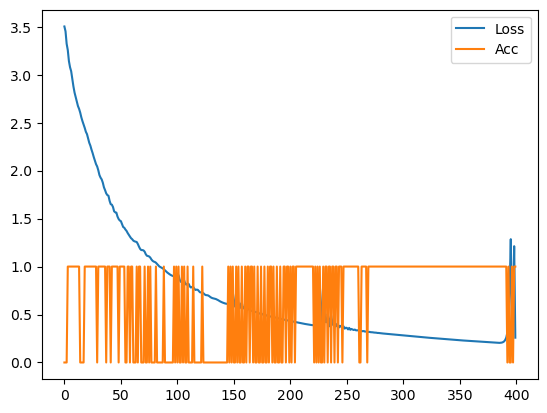

In [30]:
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(64, 16)
        self.out = torch.nn.Linear(16, 32)

    def forward(self, x, edge_index, edge_weight):
        h = self.gcn(x, edge_index, edge_weight=edge_weight).relu()
        z = self.out(h)
        return z
    
gcn = GCN()
graph_conv_train(gcn, 400, graph_dataset, lr=0.05, device=utils.try_gpu())

In [1]:
import torch
torch.save(gcn.state_dict(), "GCN_Params.pth")

NameError: name 'torch' is not defined